In [1]:
import sys
import os

exlib_path = "/shared_data0/chaenyk/exlib"
src_path = os.path.join(exlib_path, "src")
sys.path.insert(0, src_path)
import pyarrow as pa
import pyarrow_hotfix
import torch
import yaml
import argparse
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import namedtuple
import matplotlib.pyplot as plt

import exlib
from exlib.datasets.pretrain import setup_model_config, get_dataset, get_dataset, setup_model_config
from exlib.datasets.dataset_preprocess_raw import create_train_dataloader_raw, create_test_dataloader_raw, create_test_dataloader
from exlib.datasets.informer_models import InformerConfig, InformerForSequenceClassification
from tqdm.auto import tqdm
pa.PyExtensionType.set_auto_load(True)
pyarrow_hotfix.uninstall()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from example_function_supernova import Timeseries, get_llm_generated_answer, isolate_individual_features, is_claim_relevant, distill_relevant_features, calculate_expert_alignment_score

In [2]:
import openai
from openai import OpenAI

client = OpenAI(api_key="sk-None-ptTj0i2Hx0GJvjOunH0QT3BlbkFJcdhzvU2L1X5HU4F23HWB")

### Dataset

In [3]:
# load dataset
dataset = load_dataset("BrachioLab/supernova-timeseries")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [4]:
test_dataset

Dataset({
    features: ['objid', 'times_wv', 'target', 'label', 'redshift'],
    num_rows: 792
})

### Dataset Samples

In [5]:
config = InformerConfig.from_pretrained("BrachioLab/supernova-classification")
test_dataloader = create_test_dataloader_raw(
    config=config,
    dataset=test_dataset,
    batch_size=25,
    compute_loss=True
)

original dataset size: 792
remove nans dataset size: 792


In [6]:
# SNIa class 11
def find_label_in_dataloader(dataloader, target_label=11):
    for batch in dataloader:
        indices = (batch['labels'] == target_label).nonzero(as_tuple=True)[0]
        
        if len(indices) > 0:
            label_values_time = batch['past_time_features'][indices, :, :]
            label_values = batch['past_values'][indices, :, :]
            return label_values_time, label_values
    
    return None
    
label_11_past_time, label_11_past_values = find_label_in_dataloader(test_dataloader, target_label=11)

In [7]:
n = 1
time_data = label_11_past_time[n,:,0]
wv_data = label_11_past_time[n,:,1]
value_data = label_11_past_values[n,:,0]
error_data = label_11_past_values[n,:,1]

In [8]:
def plot_data_by_wavelength(times, fluxes, errors, wavelengths, title):
    wavelengths_float = []
    for w in wavelengths:
        if hasattr(w, 'item'):
            wavelengths_float.append(w.item())
        else:
            wavelengths_float.append(float(w))
    
    wavelengths_display = [round(w, 2) for w in wavelengths_float]
    unique_wavelengths_float = sorted(list(set(wavelengths_float)))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_wavelengths_float)))
    wavelength_to_color = dict(zip(unique_wavelengths_float, colors))
    
    plt.figure(figsize=(3, 3))
    legend_added = []
    
    for i in range(len(times)):
        wavelength = wavelengths_float[i]
        display_value = wavelengths_display[i]
        color = wavelength_to_color[wavelength]

        if display_value not in legend_added:
            plt.errorbar([times[i]], [fluxes[i]], yerr=[errors[i]],
                        fmt='o', color=color, capsize=5, label=f'{display_value}')
            legend_added.append(display_value)
        else:
            plt.errorbar([times[i]], [fluxes[i]], yerr=[errors[i]],
                        fmt='o', color=color, capsize=5)
    
    plt.xlabel('Time')
    plt.ylabel('Flux')
    
    plt.legend(title="Wavelengths", loc='upper right', fontsize='small', title_fontsize='small')
    plt.grid(False)
    plt.show()

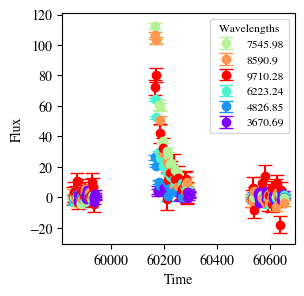

In [9]:
plot_data_by_wavelength(time_data, value_data, error_data, wv_data, 'Flux vs. Time with Error Bars by Wavelength')

In [10]:
### Extract Explanation
example = Timeseries(time=time_data, wv=wv_data, value=value_data)
analysis_result = get_llm_generated_answer(example=example, answer='Type Ia supernovae (SNIa)')
print(analysis_result)

The dataset provided represents a time series of observations for a supernova event, specifically classified as a Type Ia supernova (SNIa). Type Ia supernovae are characterized by their consistent peak luminosity, which makes them excellent standard candles for measuring cosmic distances. In the time series data, we observe a pattern of values across different wavelengths over time. The presence of specific wavelengths, such as those around 7545 Å, 8590 Å, and 9710 Å, is indicative of the spectral features associated with SNIa, such as the silicon absorption lines near 6150 Å and the absence of hydrogen lines, which are typical in other supernova types like SNII. The time series also shows a rapid increase in brightness followed by a gradual decline, a light curve shape that is characteristic of SNIa. The consistent pattern across multiple observations and the presence of these spectral features support the classification of this event as a Type Ia supernova. Additionally, the data sho

In [11]:
### Extract Explanation
example = Timeseries(time=time_data, wv=wv_data, value=value_data)
analysis_result = get_llm_generated_answer(example=example, answer='Type Ia supernovae (SNIa)')
print(analysis_result)

The dataset provided represents a time series of observations for a supernova event, specifically classified as a Type Ia supernova (SNIa). Type Ia supernovae are characterized by their consistent peak luminosity, which makes them valuable as standard candles for measuring cosmic distances. In the time series data, we observe a pattern of values across different wavelengths over time. The presence of specific wavelengths, such as 7545.98 Å, 8590.90 Å, and 9710.28 Å, is indicative of the spectral features associated with SNIa, such as the silicon absorption lines around 6150 Å and the absence of hydrogen lines, which are typical in other supernova types like SNII. The time series also shows a rapid increase in brightness followed by a gradual decline, a light curve shape characteristic of SNIa. The consistent pattern across multiple observations and the presence of these spectral features support the classification of this event as a Type Ia supernova. Additionally, the data shows a sig

In [12]:
### Make it to atomic claims
raw_atomic_claims = isolate_individual_features(analysis_result)

print("Extracted atomic claims:")
for i, claim in enumerate(raw_atomic_claims, 1):
    print(f"{i}. {claim}")

Extracted atomic claims:
1. The dataset represents a time series of observations for a supernova event.
2. The supernova event is specifically classified as a Type Ia supernova (SNIa).
3. Type Ia supernovae are characterized by their consistent peak luminosity.
4. Type Ia supernovae are valuable as standard candles for measuring cosmic distances.
5. The time series data shows a pattern of values across different wavelengths over time.
6. Specific wavelengths such as 7545.98 Å, 8590.90 Å, and 9710.28 Å are present in the data.
7. These wavelengths are indicative of the spectral features associated with SNIa.
8. SNIa spectral features include silicon absorption lines around 6150 Å.
9. SNIa lack hydrogen lines, which are typical in other supernova types like SNII.
10. The time series shows a rapid increase in brightness followed by a gradual decline.
11. The light curve shape is characteristic of SNIa.
12. The consistent pattern across multiple observations supports the classification as 

In [17]:
### Relevant claims
example = Timeseries(time=time_data, wv=wv_data, value=value_data)
answer = 'Type Ia supernovae (SNIa)'
claim_relevances = [is_claim_relevant(example, answer, raw_atomic_claim, 0.8) \
    for raw_atomic_claim in raw_atomic_claims]
claim_relevances

[True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False]

In [18]:
### Distilled relevant claims
example = Timeseries(time=time_data, wv=wv_data, value=value_data)
answer = 'Type Ia supernovae (SNIa)'

distilled_claims = distill_relevant_features(example, answer, raw_atomic_claims, 0.8)

print("Distilled relevant claims:")
for i, claim in enumerate(distilled_claims, 1):
    print(f"{i}. {claim}")

Distilled relevant claims:
1. The dataset represents a time series of observations for a supernova event.
2. The time series data shows a pattern of values across different wavelengths over time.
3. Specific wavelengths such as 7545.98 Å, 8590.90 Å, and 9710.28 Å are present in the data.


In [19]:
groundtruth_claims = [
    "Flux values are nonzero for most timestamps",
    "Multiple wavelength bands are observed per timestamp",
    "Each timestamp contains both flux and uncertainty values at least once",
    "The light curve exhibits temporal continuity."
]

print("Ground truth claims:")
for i, claim in enumerate(groundtruth_claims, 1):
    print(f"{i}. {claim}")

Ground truth claims:
1. Flux values are nonzero for most timestamps
2. Multiple wavelength bands are observed per timestamp
3. Each timestamp contains both flux and uncertainty values at least once
4. The light curve exhibits temporal continuity.


In [20]:
### Compute alignment scores
scores = calculate_expert_alignment_score(distilled_claims, groundtruth_claims)
scores

{'alignment_scores': [{'claim': 'The dataset represents a time series of observations for a supernova event.',
   'score': 5},
  {'claim': 'The time series data shows a pattern of values across different wavelengths over time.',
   'score': 5},
  {'claim': 'Specific wavelengths such as 7545.98 Å, 8590.90 Å, and 9710.28 Å are present in the data.',
   'score': 4}],
 'total_score': 5}

In [17]:
### pipeline
# Input: example, answer, explanation
# Step 1: isolate individual explanation / distill relevant features (hallucination)
# Step 2: determine expert alignment for each feature
# Step 3: aggregate (relevance / alignment / coverage)

In [18]:
### ground truth
# Not locally 0 (approximately)
# More bands per timestamp (globally)
# Error + fluxes per timestamp at least once (reason: signed to noise ratio)
# Continuity in time (Structure: Peak)